# \[GNN\] pyod examples

김보람  
2024-01-18

# pyod examples

`-` ref: https://pyod.readthedocs.io/en/latest/example.html

# knn_example

In [9]:
from pyod.models.knn import KNN   # kNN detector
from pyod.utils.data import generate_data
from pyod.utils.example import visualize

In [5]:
contamination = 0.1  # percentage of outliers
n_train = 200  # number of training points
n_test = 100  # number of testing points

X_train, X_test, y_train, y_test = generate_data(
    n_train=n_train, n_test=n_test, contamination=contamination)

In [6]:
# train kNN detector
clf_name = 'KNN'
clf = KNN()
clf.fit(X_train)

# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

# it is possible to get the prediction confidence as well
y_test_pred, y_test_pred_confidence = clf.predict(X_test, return_confidence=True)  # outlier labels (0 or 1) and confidence in the range of [0,1]

In [7]:
from pyod.utils.data import evaluate_print
# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)


On Training Data:
KNN ROC:0.8753, precision @ rank n:0.65

On Test Data:
KNN ROC:0.9811, precision @ rank n:0.9

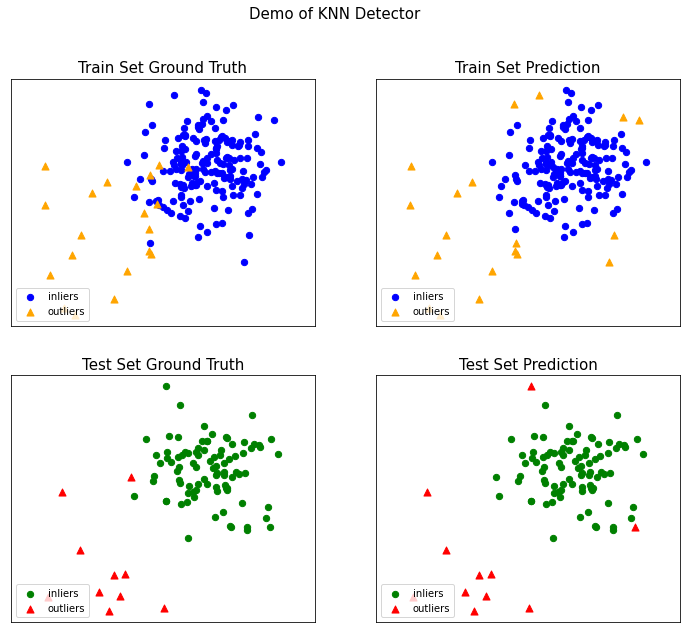

In [10]:
visualize(clf_name, X_train, y_train, X_test, y_test, y_train_pred,
          y_test_pred, show_figure=True, save_figure=False)

# Model Combination Example

Example of combining multiple base outlier scores. Four combination
frameworks are demonstrated:

1.  **Average**: take the average of all base detectors
2.  **maximization** : take the maximum score across all detectors as
    the score
3.  **Average of Maximum (AOM)**
4.  **Maximum of Average (MOA)**

위 4개의 프레임워크를 사용하여 KNN 이상치 감지 모델 평가

In [13]:
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.io import loadmat

from pyod.models.knn import KNN
from pyod.models.combination import aom, moa, average, maximization, median
from pyod.utils.utility import standardizer
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print


In [15]:

if __name__ == "__main__":

    # Define data file and read X and y
    # Generate some data if the source data is missing
    mat_file = 'cardio.mat'
    try:
        mat = loadmat(os.path.join('data', mat_file))

    except TypeError:
        print('{data_file} does not exist. Use generated data'.format(
            data_file=mat_file))
        X, y = generate_data(train_only=True)  # load data
    except IOError:   # 존재하지 않을 때 .. 
        print('{data_file} does not exist. Use generated data'.format(
            data_file=mat_file))
        X, y = generate_data(train_only=True)  # load data
    else:
        X = mat['X']
        y = mat['y'].ravel()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

    # standardizing data for processing
    X_train_norm, X_test_norm = standardizer(X_train, X_test)

    n_clf = 20  # number of base detectors 이상치 초기화

    # Initialize 20 base detectors for combination
    k_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140,
              150, 160, 170, 180, 190, 200]

    train_scores = np.zeros([X_train.shape[0], n_clf])   # 훈련 데이터의 행 수
    test_scores = np.zeros([X_test.shape[0], n_clf])

    print('Combining {n_clf} kNN detectors'.format(n_clf=n_clf))

    for i in range(n_clf):
        k = k_list[i]

        clf = KNN(n_neighbors=k, method='largest')
        clf.fit(X_train_norm)

        train_scores[:, i] = clf.decision_scores_
        test_scores[:, i] = clf.decision_function(X_test_norm)

    # Decision scores have to be normalized before combination
    train_scores_norm, test_scores_norm = standardizer(train_scores,
                                                       test_scores)
    # Combination by average
    y_by_average = average(test_scores_norm)
    evaluate_print('Combination by Average', y_test, y_by_average)

    # Combination by max
    y_by_maximization = maximization(test_scores_norm)
    evaluate_print('Combination by Maximization', y_test, y_by_maximization)

    # Combination by median
    y_by_median = median(test_scores_norm)
    evaluate_print('Combination by Median', y_test, y_by_median)

    # Combination by aom
    y_by_aom = aom(test_scores_norm, n_buckets=5)
    evaluate_print('Combination by AOM', y_test, y_by_aom)

    # Combination by moa
    y_by_moa = moa(test_scores_norm, n_buckets=5)
    evaluate_print('Combination by MOA', y_test, y_by_moa)

cardio.mat does not exist. Use generated data
Combining 20 kNN detectors
Combination by Average ROC:0.0, precision @ rank n:0.0
Combination by Maximization ROC:0.0055, precision @ rank n:0.0
Combination by Median ROC:0.0, precision @ rank n:0.0
Combination by AOM ROC:0.0055, precision @ rank n:0.0
Combination by MOA ROC:0.0083, precision @ rank n:0.0

`-` 참고(홈페이지에서 나온 결과값)

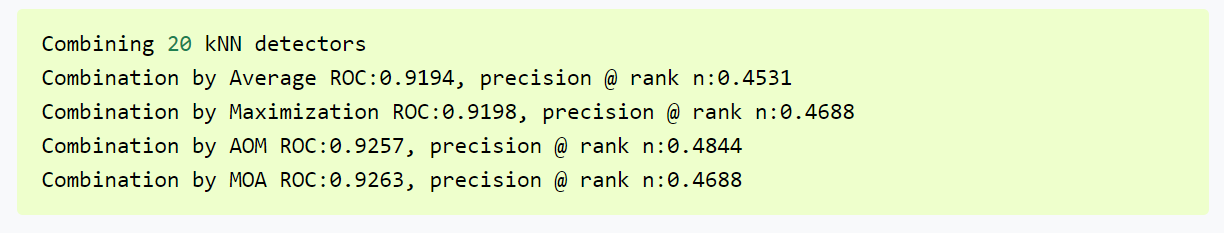

# Thresholding Example

Example of using Angle-base outlier detection (ABOD) for outlier
detection

In [22]:
from pyod.models.knn import KNN   # kNN detector
from pyod.models.thresholds import FILTER  # Filter thresholder

In [23]:
contamination = 0.1  # percentage of outliers
n_train = 200  # number of training points
n_test = 100  # number of testing points

X_train, X_test, y_train, y_test = generate_data(
    n_train=n_train, n_test=n_test, contamination=contamination)

In [24]:
# train kNN detector and apply FILTER thresholding
clf_name = 'KNN'
clf = KNN(contamination=FILTER())
clf.fit(X_train)

# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores